## Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

### Part 1: Loading, clean and perform EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import Grouper
import datetime as dt
import seaborn as sns

plt.style.use('ggplot')

In [2]:
#load json file into a pandas df
raw_data = pd.read_json('ultimate_data_challenge.json')

In [3]:
#check out raw_data
raw_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


We can see we have some null values in the avg_rating_of_driver, average_rating_by_driver and phone cols. We will look at each of these individually momentarily.

Dtypes all seem good, except the two date features currently are dtype 'object' and will need to be converted to 'datetime64' so we can use them for calculations.

I'd like to check the descriptions for each column and also check for duplicate entries in the dataframe.

In [5]:
raw_data.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [6]:
raw_data.describe(include=[object])

,city,signup_date,last_trip_date,phone
count,50000,50000,50000,49604
unique,3,31,182,2
top,Winterfell,2014-01-18,2014-06-29,iPhone
freq,23336,2948,2036,34582


In [7]:
raw_data.duplicated().value_counts()

False    49992
True         8
dtype: int64

We have 8 duplicated rows, which we can go ahead and delete now.

In [8]:
raw_data.drop_duplicates(inplace=True)

Text(0.5, 1.0, 'type of phone')

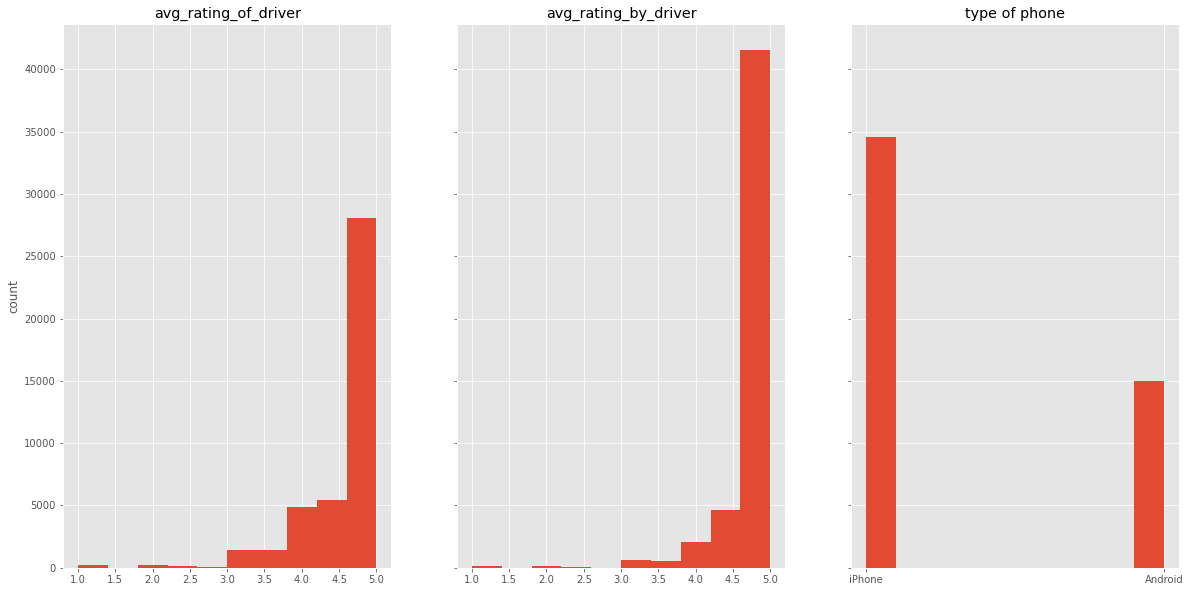

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[20,10], sharey=True)
raw_data['avg_rating_of_driver'].hist(ax = ax1)
ax1.set_title('avg_rating_of_driver')
ax1.set_ylabel('count')
raw_data['avg_rating_by_driver'].hist(ax = ax2)
ax2.set_title('avg_rating_by_driver')
raw_data['phone'].hist(ax = ax3)
ax3.set_title('type of phone')



These histograms of the distributions of the missing values can help inform our replacement strategy. I'll use:
    - avg_rating_of_driver: median value
    - avg_rating_by_drive: median value
    - phone: randomly select iPhone or Android, at the ratio of the two types of phones in the original distribution

In [10]:
#calculate the ratio of phone types
phone_ratio = raw_data['phone'].value_counts(normalize=True)
print(phone_ratio)

iPhone     0.697193
Android    0.302807
Name: phone, dtype: float64


In [11]:
#fill missing values in the phone col proportionally to the remaining data
raw_data['phone'] = raw_data['phone'].fillna(pd.Series(np.random.choice(['iPhone', 'Android'], p=[0.697,0.303], size=len(raw_data))))

#check to make sure all missing values have been filled
print("remaining missing values: {}".format(raw_data['phone'].isna().sum()))

#check to make sure overall ratio is the same
phone_ratio = raw_data['phone'].value_counts(normalize=True)
print(phone_ratio)

#the ratios identical up to the 3 significant figures included in the calculation--great!

remaining missing values: 0
iPhone     0.697172
Android    0.302828
Name: phone, dtype: float64


In [12]:
#replace missing values in avg_rating_of_driver and avg_rating_by_drive with median values for each column
raw_data['avg_rating_of_driver'].fillna(raw_data['avg_rating_of_driver'].median(), inplace=True)
raw_data['avg_rating_by_driver'].fillna(raw_data['avg_rating_by_driver'].median(), inplace=True)

#check that all values are filled:
print("remaining missing values in 'avg_rating_of_driver': {}".format(raw_data['avg_rating_of_driver'].isna().sum()))
print("remaining missing values in 'avg_rating_by_driver': {}".format(raw_data['avg_rating_by_driver'].isna().sum()))



remaining missing values in 'avg_rating_of_driver': 0
remaining missing values in 'avg_rating_by_driver': 0


Great, that takes care of all the missing values and all the duplicates. Now I'm going to check that the distributions for each column look reasonable:

array([[<AxesSubplot:title={'center':'trips_in_first_30_days'}>,
        <AxesSubplot:title={'center':'avg_rating_of_driver'}>,
        <AxesSubplot:title={'center':'avg_surge'}>],
       [<AxesSubplot:title={'center':'surge_pct'}>,
        <AxesSubplot:title={'center':'weekday_pct'}>,
        <AxesSubplot:title={'center':'avg_dist'}>],
       [<AxesSubplot:title={'center':'avg_rating_by_driver'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

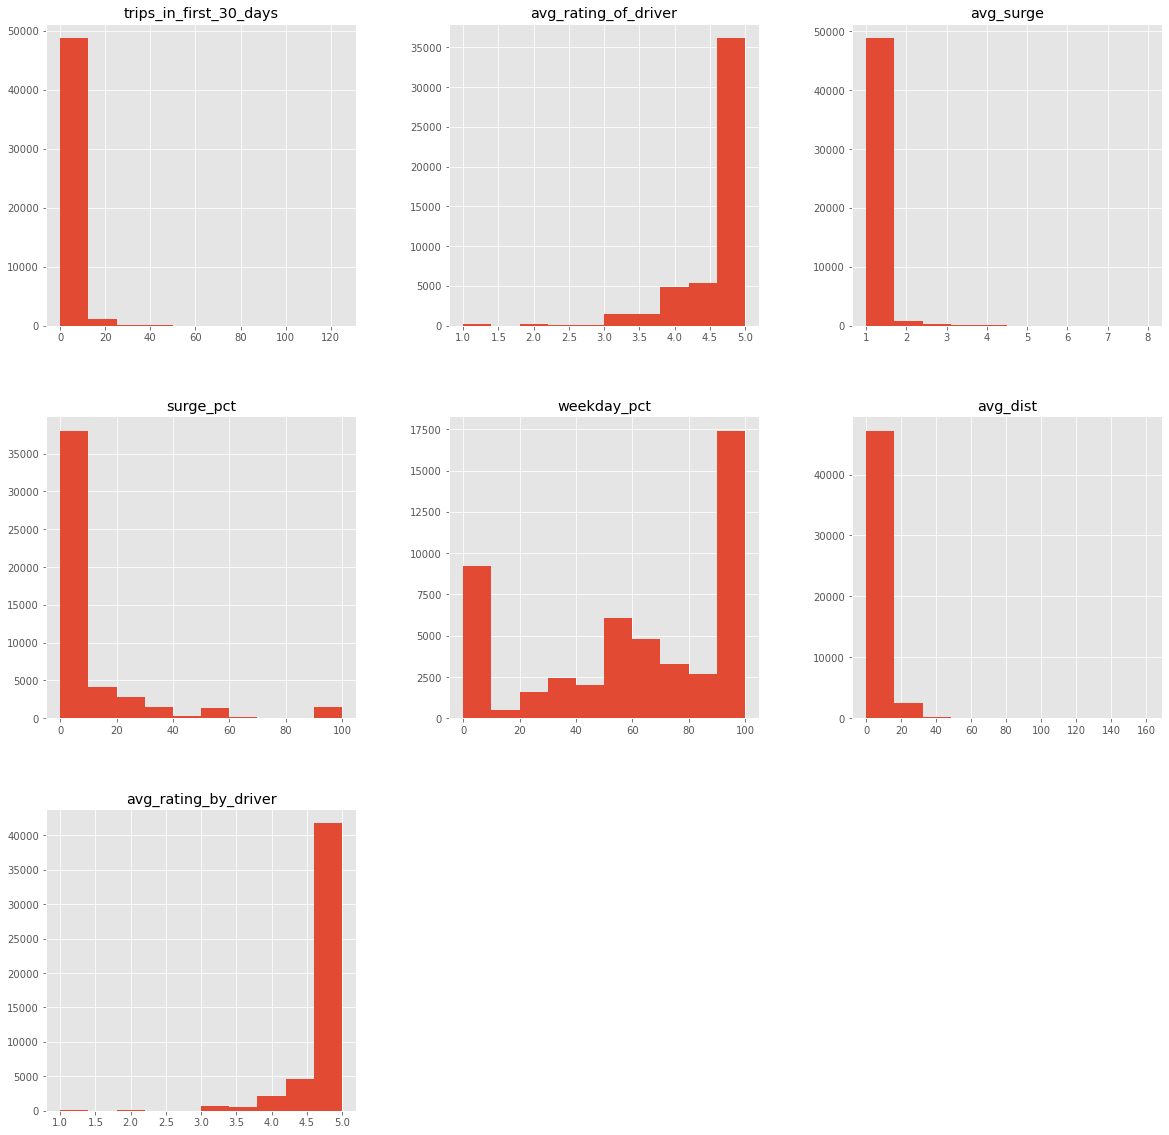

In [13]:
raw_data.hist(figsize=[20,20])

These distributions are mostly single tailed, indicating that most users fall pretty closely together on these features. 

The one exception is the percentage of rides taken on weekdays, where we see a split distribution. Some riders use the app exclusively on weekdays, some exclusively on weekends, and some somewhere in between the two extremes. This makes intuitive sense with the logic of how some riders might use our service mostly to get to/from work during the work week, while some may tend to use our service as a means of getting around during weekend times exclusively.

Before I look at the distributions of the dates and calculate the retained users, I need to cast the date columns to the datatype datetime and the replace True/False in the Boolean column with 1/0.

In [14]:
#convert date cols to datetime and check for success
raw_data['signup_date'] = pd.to_datetime(raw_data['signup_date'])
raw_data['last_trip_date'] = pd.to_datetime(raw_data['last_trip_date'])
print(raw_data.signup_date.dtype)
print(raw_data.last_trip_date.dtype)

#convert boolean column to numeric for visualization
raw_data.replace(to_replace=(True, False), value=[1,0], inplace=True)


datetime64[ns]
datetime64[ns]


Text(0.5, 1.0, 'ultimate_black_user')

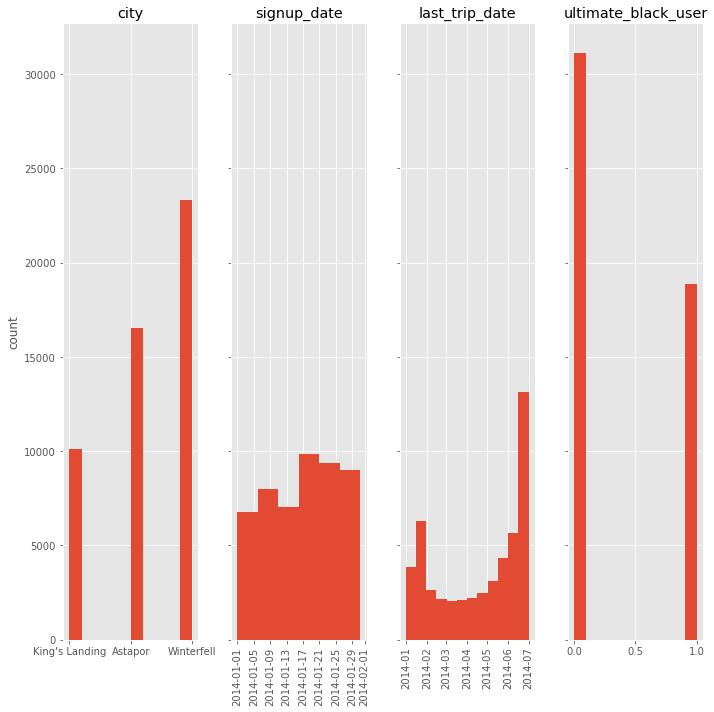

In [15]:
#create distribution visualizations
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=[10,10],tight_layout=True, sharey=True)
raw_data['city'].hist(ax = ax1)
ax1.set_title('city')
ax1.set_ylabel('count')
raw_data['signup_date'].hist(ax = ax2, bins= 6, xrot=90)
ax2.set_title('signup_date')
raw_data['last_trip_date'].hist(ax = ax3, bins = 12, xrot=90)
ax3.set_title('last_trip_date')
raw_data['ultimate_black_user'].hist(ax=ax4)
ax4.set_title('ultimate_black_user')


Okay, we can see a few things in these histograms:
1. all data is from riders in three cities
2. all data is from riders who signed up in January of 2014
3. the date of last ride for these riders is split and ranges from January 2014 to July of 2014.
4. The majority of users are not ultimate_black status, but a fair proportion are.

Finally, it's time to create the feature we're actually interested in: which users were considered retained v. not retained?
As a reminder, we consider a user retained if their last ride was within the preceeding 30 days. What's the latest date we have information for, anyway?


We will be building a predictive model to predict whether a user will be active in their 6th month on the system. For all of these users, that will be the month of July. The latest date included in the 'last_trip_date' col is 07/01/2014, so we'll use that as the benchmark from which we'll measure the 30 day activity period.

In [16]:
last_date = raw_data['last_trip_date'].max()
print('The last date we have trip information for is: {}'.format(last_date))

The last date we have trip information for is: 2014-07-01 00:00:00


In [17]:
#create a new column to classify whether a user is active based on whether their last ride was within 30 days of 07/01/2014
raw_data['active'] = ((last_date - raw_data['last_trip_date']).dt.days <=30)

raw_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9,False


In [18]:
#print the proportions of active and inactive users
print(raw_data.active.value_counts(normalize = True))

False    0.62386
True     0.37614
Name: active, dtype: float64


#### 37.6% of the observed users were active in their 6th month on the system, while 62.4% of observed users were inactive. 

In [19]:
#cast boolean "active" col to 1/0 for later modeling:
raw_data.replace(to_replace=(True, False), value=[1,0], inplace=True)

#save raw_data to simply "df"
df = raw_data

## Part 2: Building and Evaluating a Model:

Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

At it's core, this is a binary classification problem: based on the measurable factors we know about each driver, we need to build a model that will predict whether they'll still be active during their 6th month in the system.

I've already created the target variable "active" that we'll want to predict based on the other features in df.
I tend to like to try a few models to select which performs best in cross-validation. 
For this problem it makes sense to try a logreg model (of course!), and I'll also see how a Random Forest and XGBoost model do with the data. 
To evaluate the final performance of each model, I'll test on a held-out test set (20% of the original dataframe).
We'll look at the confusion matrix and classification report of each model, ROC and AUC.

In [20]:
#one-hot encode whole df to prepare for machine learning modeling
df = pd.get_dummies(df)

#drop datetime cols to prepare for machine learning
df = df.drop(columns=['last_trip_date','signup_date'])
df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,1,0,1,0,0,1
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,1,0,0,1,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,1,0,0,0,1
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,0,1,0,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,0,0,1,1,0


In [21]:
#begin by splitting df into X and y:
X = df.drop(columns='active')
y = df['active']

#import train_test_split
from sklearn.model_selection import train_test_split

# split X, y into training and testing sets, shuffling and stratifying the data based on the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=df[['active']])

In [22]:
#import modeling libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#import model selection libraries
from sklearn.model_selection import cross_val_score

#import scoring metrics and visualizers
from sklearn.metrics import roc_auc_score, plot_roc_curve, plot_precision_recall_curve,  confusion_matrix,  classification_report, accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer

#import optuna for bayesian hyper-parameter optimization
import optuna

In [23]:
#dampen verbosity on optuna trial output (trust me)
optuna.logging.set_verbosity(optuna.logging.WARNING)

#set up a scorer function that maximizes roc-auc. This will be used as the basis of the optuna optimization and model selection
roc_auc_scorer = make_scorer(roc_auc_score)

#set up optuna trial to select the best model
def objective(trial):
    #define which models we'll try
    classifier_name = trial.suggest_categorical("classifier", ["LogReg", "RandomForest", "XGBoost"])
    #define parameter space for Logistic Regression model
    if classifier_name == "LogReg":
        logreg_penalty = trial.suggest_categorical("logreg_penalty",  ["none", "l2"])
        logreg_c = trial.suggest_float("logreg_c", 1e-10, 1e10, log=True)
        classifier_obj = LogisticRegression(penalty = logreg_penalty, C=logreg_c, random_state=42)

    #define parameter space for XGBoost
    elif classifier_name == "XGBoost":
        xgb_gamma = trial.suggest_float("xgb_gamma", 0.1, 1.0)
        xgb_maxd = trial.suggest_int("xgb_maxd", 3, 12)
        xgb_lambda = trial.suggest_float("xgb_lambda", 1e-2, 1e0, log=True)
        xgb_alpha = trial.suggest_float("xgb_alpha", 0, 1.0)
        classifier_obj = XGBClassifier(gamma = xgb_gamma, max_depth=xgb_maxd, reg_alpha=xgb_alpha, reg_lambda=xgb_lambda, use_label_encoder=False, eval_metric='mlogloss')
    
    #define parameter space for Random Forest
    else:
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32)
        rf_max_features = trial.suggest_int("rf_max_features", 1, 15)
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 2, 32)
        classifier_obj = RandomForestClassifier(
            max_depth=rf_max_depth, n_estimators=rf_n_estimators, max_features=rf_max_features, random_state=42)

    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1, cv=5, scoring=roc_auc_scorer)
    auroc = score.mean()
    return auroc

if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=200)
    print(study.best_trial)

/Users/cortega/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/cortega/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/cortega/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/cortega/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/cortega/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/cortega/opt/anaconda3/lib/python3

FrozenTrial(number=197, values=[0.7669272013033938], datetime_start=datetime.datetime(2022, 8, 19, 20, 19, 34, 336354), datetime_complete=datetime.datetime(2022, 8, 19, 20, 19, 37, 368645), params={'classifier': 'XGBoost', 'xgb_gamma': 0.43893817565211823, 'xgb_maxd': 5, 'xgb_lambda': 0.18231120044361732, 'xgb_alpha': 0.9427701741653935}, distributions={'classifier': CategoricalDistribution(choices=('LogReg', 'RandomForest', 'XGBoost')), 'xgb_gamma': UniformDistribution(high=1.0, low=0.1), 'xgb_maxd': IntUniformDistribution(high=12, low=3, step=1), 'xgb_lambda': LogUniformDistribution(high=1.0, low=0.01), 'xgb_alpha': UniformDistribution(high=1.0, low=0.0)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=197, state=TrialState.COMPLETE, value=None)


In [32]:
#define best_model using the best model from the optuna study, above--an XGBoostClassifier model with average cross validation auc = 0.7675
best_model = XGBClassifier(gamma = 0.734120327760596, max_depth=4, reg_alpha=0.8107788503766244, reg_lambda=0.013037689525077405, use_label_encoder=False, eval_metric='mlogloss')

#train best_model on entire training set:
best_model.fit(X_train,y_train)
#
#get predictions
y_pred = best_model.predict_proba(X_test)
y_pred_class = best_model.predict(X_test)



In [36]:
print('y_pred: {}'.format(y_pred))
print('y_test: {}'.format(y_test.to_numpy()))

#calculate and print KPIs
print('Final Model KPIs:')
print("AUC score: {}".format(roc_auc_score(y_test, y_pred[:,1])))
print("Accuracy score: {}".format(accuracy_score(y_test, y_pred_class)))
print("F1 score: {}".format(f1_score(y_test, y_pred_class)))
print("Precision: {}".format(precision_score(y_test, y_pred_class)))
print("Recall: {}".format(recall_score(y_test, y_pred_class)))



y_pred: [[0.15968901 0.840311  ]
 [0.87223583 0.12776418]
 [0.9359382  0.06406183]
 ...
 [0.5564452  0.44355482]
 [0.7811739  0.21882612]
 [0.47184414 0.52815586]]
y_test: [1 0 0 ... 0 0 1]
Final Model KPIs:
AUC score: 0.859646330579813
Accuracy score: 0.7924792479247925
F1 score: 0.7084445693410145
Precision: 0.75119189511323
Recall: 0.6703004520074448


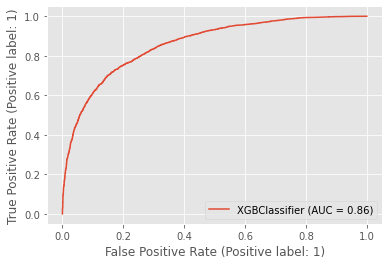

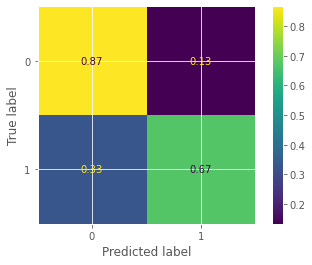

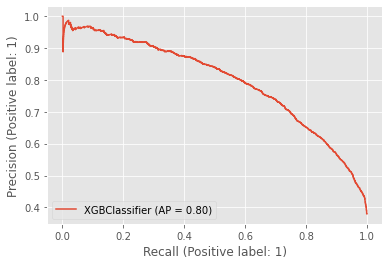

In [26]:
#roc_auc_score, plot_roc_curve, plot_precision_recall_curve,  confusion_matrix,  classification_report, accuracy_score, precision_score, recall_score, f1_score
#RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay

plot_roc_curve(best_model, X_test, y_test)
plot_confusion_matrix(best_model, X_test, y_test, normalize='true')
plot_precision_recall_curve(best_model, X_test, y_test)